<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/Market_Analysis_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
# !pip install kneed
# !pip install alpaca-trade-api
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install yfinance

[***************************************178%******************************************]  1779 of 1000 completed

### Market Analysis for Paper Trading




0.   Connect to the market data provider api
1.   Get Data
2.   Filter available assets in Alpaca Market
3.   Find Cointegrated pairs for Statistical Arbitrage
4.   Pick cointegrated pairs and detect trend with HMM Clustering
5.   Detect entry point, target price and stop price by the chart
6.   Create trading report.



#### Imports

In [141]:
from datetime import datetime
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from pandas_datareader.nasdaq_trader  import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learing related imports
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# cointegration and statistic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# market data
import alpaca_trade_api as alpaca
import yfinance as yf

#### 0.0 Connect to the market data provider

In [143]:
api = alpaca.REST(key_id, secret_key, 'https://paper-api.alpaca.markets')
api.get_account()

Account({   'account_blocked': False,
    'account_number': 'PA3OJP423MLE',
    'accrued_fees': '0',
    'balance_asof': '2022-12-23',
    'bod_dtbp': '0',
    'buying_power': '200000',
    'cash': '100000',
    'created_at': '2022-12-22T19:56:32.073526Z',
    'crypto_status': 'ACTIVE',
    'crypto_tier': 0,
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'effective_buying_power': '200000',
    'equity': '100000',
    'id': 'd38ec6c2-a23b-4708-a064-cda26744e218',
    'initial_margin': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '2',
    'non_marginable_buying_power': '100000',
    'pattern_day_trader': False,
    'pending_transfer_in': '0',
    'portfolio_value': '100000',
    'position_market_value': '0',
    'regt_buying_power': '200000',
    'short_market_value': '0',
    'shorting_enabled': True,
    'sma': '100000',
    'status': 'ACTIVE'

#### 1.0 Get Data

In [144]:
# get list of available stocks 
asset_list =api.list_assets()
asset_list = [asset.symbol for asset in asset_list if (asset.status == 'active') & (asset.exchange =='OTC')]
len(asset_list), asset_list[:10]

(396,
 ['NWFFF',
  'ACLLY',
  'ACUT',
  'AFIIQ',
  'ALJJ',
  'ALFIQ',
  'ARGGY',
  'AVISF',
  'AXAS',
  'BTLCY'])

In [145]:
start_date = '2017-01-01'
end_date = '2022-12-27'
data = yf.download(asset_list, start_date, end_date)
data = data['Adj Close']

[*********************100%***********************]  396 of 396 completed

6 Failed downloads:
- DOGE/USDT: No timezone found, symbol may be delisted
- HUGS.U: No timezone found, symbol may be delisted
- ACMSY: No timezone found, symbol may be delisted
- EAI: No data found for this date range, symbol may be delisted
- FLAG.U: No timezone found, symbol may be delisted
- EFHTR: Period 'max' is invalid, must be one of ['1d', '5d']


#### 1.1 Clear Data

In [147]:
data.dropna(inplace=True, axis=1)
data.head()

,AAT,AAU,ACR,ACTG,AE,AFTY,AGO,ALNY,ASPU,ATLO,...,VTIP,VXF,VYNT,WBIG,WIX,WPC,XLY,XPO,XSHD,YARIY
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,37.319561,1.01,21.825386,6.75,33.771427,11.384375,35.478935,38.639999,3.360,27.573645,...,45.296101,90.807487,210.0,19.177464,44.950001,42.994507,77.646408,15.113817,19.151621,15.514269
2017-01-04,38.047916,0.97,22.315557,6.95,35.231316,11.676950,35.852394,41.290001,3.420,28.491381,...,45.314533,92.407364,210.0,19.365774,46.200001,43.552971,78.680061,15.611847,19.361462,15.661585
2017-01-05,38.117283,1.02,22.315557,7.10,34.514027,11.763768,35.196552,41.349998,3.420,27.156494,...,45.369812,91.701538,217.5,19.274361,47.000000,44.154385,78.623169,15.117276,19.158243,16.165543
2017-01-06,37.917854,1.00,22.134968,6.70,34.210243,11.616178,35.278545,42.230000,3.240,27.323357,...,45.296101,91.701538,217.5,19.379490,47.450001,43.853683,79.011948,15.106900,18.971224,16.010479
2017-01-09,37.362923,1.01,21.825386,6.35,33.518280,11.564087,35.041710,43.500000,3.408,26.906202,...,45.323746,91.165108,229.5,19.315502,47.900002,43.288055,78.945572,14.972017,18.842365,15.967835


In [148]:
data.value_counts().isnull().sum()

0

#### 2.0 Feature Engineering

In [149]:
# create dataframe which cointains return and volatility information
df_extended = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_extended['volatility'] = data.pct_change().std() * np.sqrt(255)
df_extended.head()

,returns,volatility
AAT,-0.000365,0.335627
AAU,0.046185,0.754998
ACR,0.081547,0.725073
ACTG,0.022728,0.477619
AE,0.132230,0.464706


In [150]:
# df_extended = df_extended.fillna(method="ffill")
# df_extended.isnull().any()
# df_extended = df_extended.replace([np.inf, -np.inf], 0)

In [151]:
df_extended.describe()

,returns,volatility
count,197.000000,197.000000
mean,0.128955,0.491876
std,0.247879,0.471835
min,-1.016777,0.015973
25%,0.021595,0.273845
50%,0.085741,0.359531
75%,0.175232,0.501887
max,2.084294,3.732560


In [152]:
# scaling the data
scaler = StandardScaler()
scaler = scaler.fit_transform(df_extended)
df_scaled = pd.DataFrame(scaler, index=df_extended.index, columns=df_extended.columns)
df_scaled.head()

,returns,volatility
AAT,-0.523035,-0.331995
AAU,-0.334763,0.559079
ACR,-0.191743,0.495493
ACTG,-0.429634,-0.030294
AE,0.013247,-0.057729


#### 3.0 K-Means Clustering

In [170]:
# find the optimal number of clusters 
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"The optimal number of clusters: {c}")

[****************************************************231%*******************************************************]  915 of 396 completedThe optimal number of clusters: 4


In [171]:
# fit the model
kmeans = KMeans(n_clusters=c)
kmeans.fit(X)
preds = kmeans.predict(df_scaled)

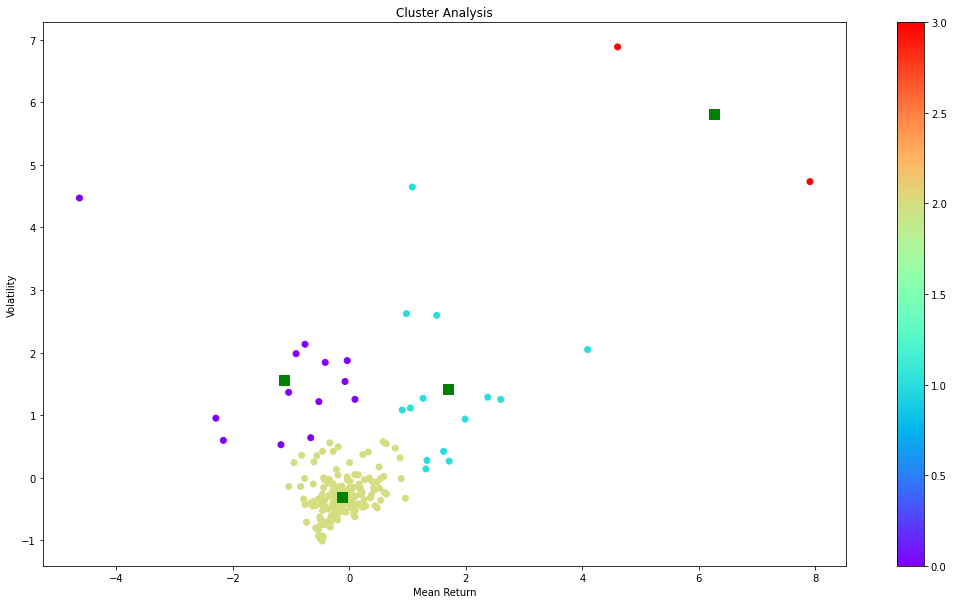

In [172]:
# show results
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=kmeans.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [173]:
# return the clustered series
clustered_series = pd.Series(index=X.index, data=kmeans.labels_.flatten())
# clustered_series = clustered_series[clustered_series != -1]
clustered_series

AAT      2
AAU      2
ACR      2
ACTG     2
AE       2
        ..
WPC      2
XLY      2
XPO      2
XSHD     2
YARIY    2
Length: 197, dtype: int32

[****************************************************231%*******************************************************]  916 of 396 completed

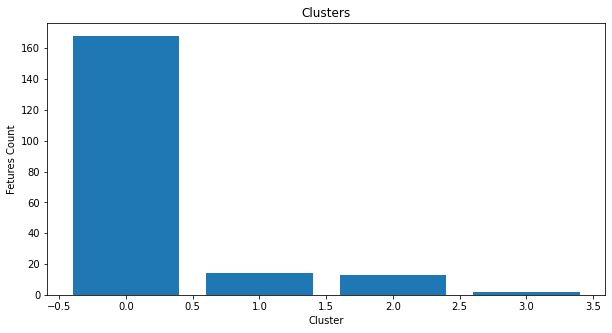

In [174]:
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Fetures Count")
plt.show()

In [ ]:
# if there any significant outliers can be detected it should remove from the dataset, but at this point it has been worked with small kind of test dataset which not contains it.
clustered_series_rem_ol = clustered_series[clustered_series < 3]